## Ejercicio 3

_Iris_ es el género de una planta herbácea con flores que se utilizan en decoración. Dentro de este género existen muy diversas especies, entre las que se han estudiado: _Iris setosa_, _Iris versicolor_ e _Iris virginica_ (ver Figura 2).

Estas tres especies pueden distinguirse según las dimensiones de sus pétalos y sépalos. Un grupo de investigadores ha recopilado la información correspondiente a las longitudes y anchos de los pétalos y sépalos de 50 plantas de cada especie. En el archivo `iris81_trn.csv` se encuentra el conjunto de entrenamiento, y en `iris81_tst.csv` el de prueba, generado a partir de estas mediciones (en cm), junto con un código binario que indica la clase de cada meustra (Especie) reconocida por el grupo de investigadores ([-1, -1, 1] = _setosa_, [-1, 1, -1] = _versicolor_, [1, -1, -1] = _virginica_).

Determine la estructura óptima de un perceptrón multicapa para resolver este problema. Explore cómo varía el desempeño al usar distintas tasas de aprendizaje, y para cada caso grafique las curvas de error cuadrático total y error de clasificación en función de las épocas de entrenamiento.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import PerceptronMulticapa

def cargarCSV(csvRelativePath, delimeter = ',') -> np.ndarray[any]:
    this_folder = os.path.abspath('') 
    fullPath = os.path.join(this_folder, csvRelativePath)
    return np.loadtxt(fullPath, dtype=float, delimiter=delimeter)

# ===== PARAMETROS =====
max_epocas = 200
target_error = 0.01

# leer archivos
trnFileIris = cargarCSV('./data/iris81_trn.csv')
tstFileIris = cargarCSV('./data/iris81_tst.csv')

# ===== TRAINING =====
x = trnFileIris[:,:-3]
yd = trnFileIris[:,-3:]

# Definir variantes de diseño
η = [0.1, 0.05, 0.01, 0.001]
neuronas = [[1,3], [2,3], [2,2,3], [3,3], [3,2,3]]

redes: list[list[PerceptronMulticapa.PerceptronMulticapa]] = [[None for i in range(len(η))] for j in range(len(neuronas))]
trnErr: list[list[float]] = [[None for i in range(len(η))] for j in range(len(neuronas))]

# Entrenar todos los diseños
for j in range(len(neuronas)):
    for i in range(len(η)):
        # Entrenar 5 con el mismo diseño y quedarnos con la mejor
        cant_intentos = 5
        candidatas: list[PerceptronMulticapa.PerceptronMulticapa] = [None for _ in range(cant_intentos)]
        err: list[float] = [None for _ in range(cant_intentos)]

        for intento in range(cant_intentos):
            # crear y entrenar NN
            candidatas[intento] = PerceptronMulticapa.PerceptronMulticapa(
                cant_entradas=x.shape[1],
                capas=neuronas[j],
                max_epocas=max_epocas,
                tasa_aprendizaje=η[i]
            )

            err[intento] = candidatas[intento].entrenar(x,yd,0.01)

        mejorIndex = np.argmin(err)
        redes[j][i] = candidatas[mejorIndex]
        trnErr[j][i] = err[mejorIndex]

### Errores

In [2]:
# test
x_tst = tstFileIris[:,:-3]
yd_tst = tstFileIris[:,-3:]
tstErr = [[redes[j][i].test(x_tst,yd_tst) for i in range(len(η))] for j in range(len(neuronas))]

from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Neuronas", "η", f"Training ({x.shape[0]} casos)", f"Testing ({x_tst.shape[0]} casos)"]

for j in range(len(neuronas)):
    str_neuronas = ""
    for n in neuronas[j]:
        str_neuronas += f"{n}, "
    for i in range(len(η)):
        table.add_row([str_neuronas, η[i], trnErr[j][i], tstErr[j][i]])

print(table)

+-----------+-------+----------------------+---------------------+
|  Neuronas |   η   | Training (111 casos) |  Testing (37 casos) |
+-----------+-------+----------------------+---------------------+
|   1, 3,   |  0.1  | 0.009009009009009009 | 0.08108108108108109 |
|   1, 3,   |  0.05 | 0.009009009009009009 | 0.05405405405405406 |
|   1, 3,   |  0.01 | 0.009009009009009009 |         0.0         |
|   1, 3,   | 0.001 |  0.2882882882882883  |  0.2972972972972973 |
|   2, 3,   |  0.1  | 0.009009009009009009 |         0.0         |
|   2, 3,   |  0.05 | 0.009009009009009009 | 0.08108108108108109 |
|   2, 3,   |  0.01 | 0.009009009009009009 |         0.0         |
|   2, 3,   | 0.001 | 0.009009009009009009 |         0.0         |
| 2, 2, 3,  |  0.1  | 0.009009009009009009 |         0.0         |
| 2, 2, 3,  |  0.05 | 0.009009009009009009 |         0.0         |
| 2, 2, 3,  |  0.01 | 0.009009009009009009 | 0.08108108108108109 |
| 2, 2, 3,  | 0.001 |  0.2882882882882883  |  0.29729729729729

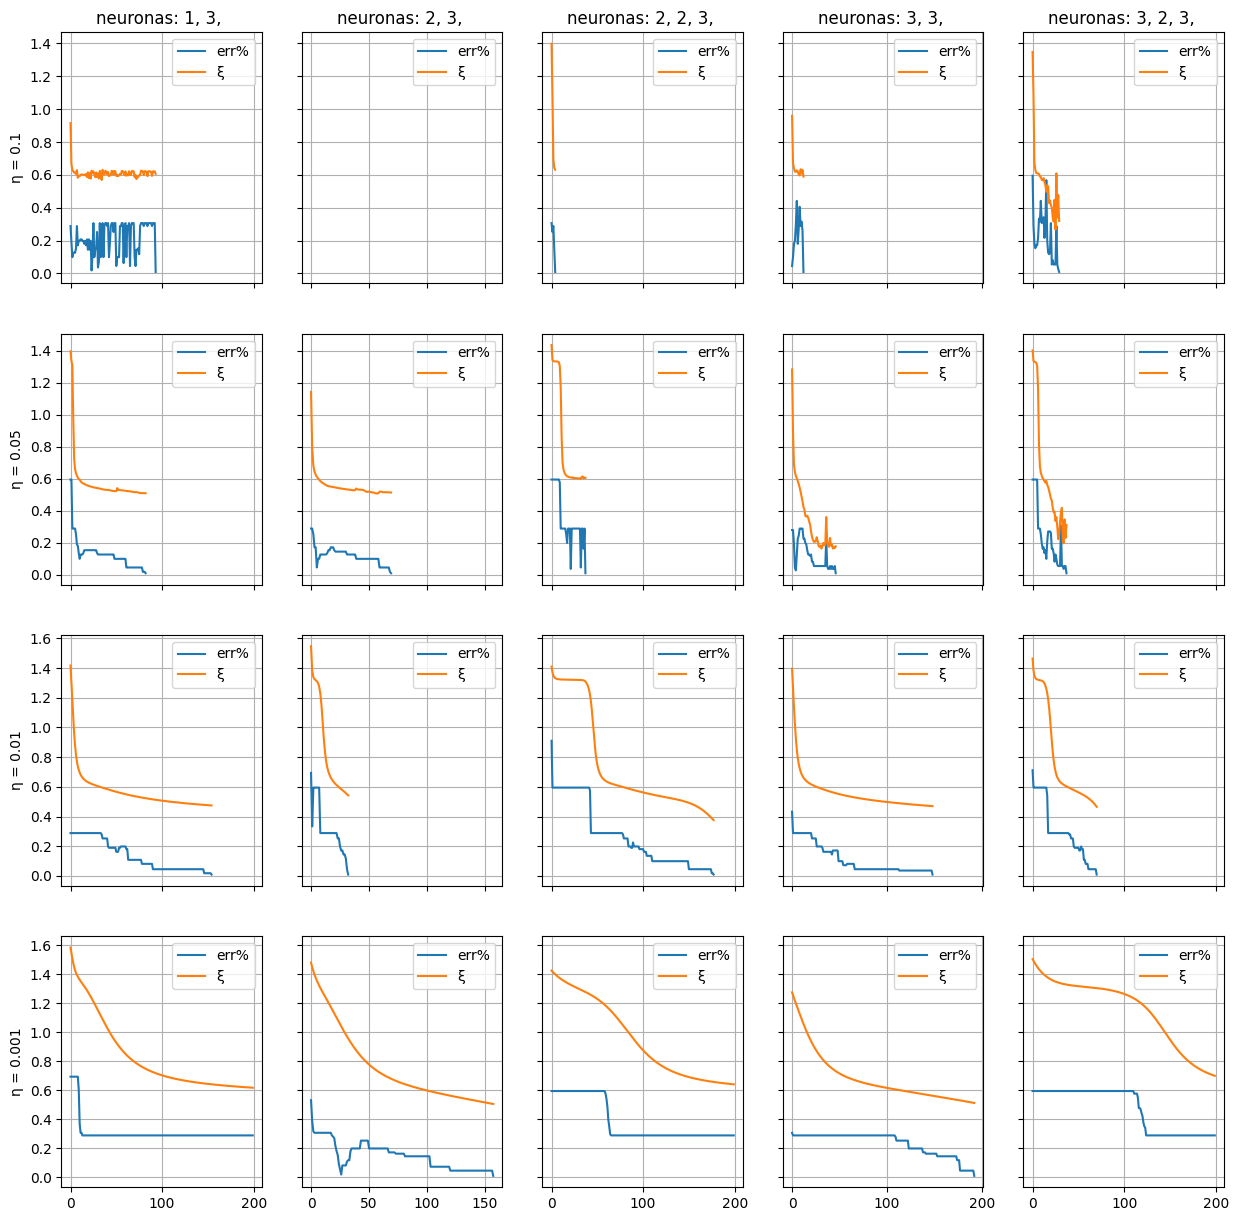

In [3]:
# Gráficas
fig, ax = plt.subplots(len(η), len(neuronas), sharex="col", sharey="row")
fig.set_figwidth(15)
fig.set_figheight(15)

# graficas de error
for j in range(len(neuronas)):
    label = "neuronas: "
    for n in neuronas[j]:
        label += f"{n}, "
    ax[0,j].set_title(label)
    for i in range(len(η)):
        if j == 0:
            ax[i,j].set_ylabel(f"η = {η[i]}")
        ax[i,j].grid()
        ax[i,j].plot(redes[j][i].error_history, label="err%")
        ax[i,j].plot(redes[j][i].quaderror_history, label="ξ")
        ax[i,j].legend()

plt.show()

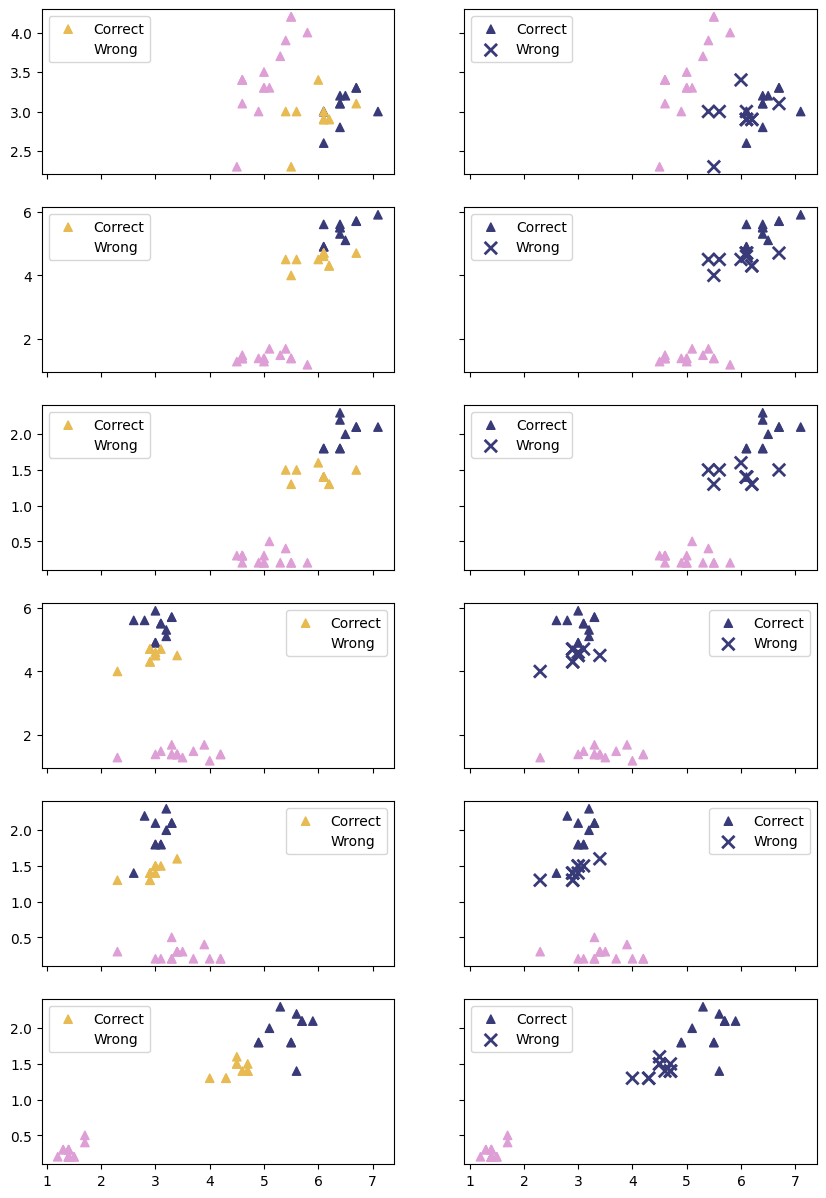

In [23]:
# ===== Regiones de decision =====
def plot_decision_region(red, x, yd, axi, xy):
    (i,j) = xy
    # predict on training set
    Y_pred = np.argmax(red.predict(x), axis=1)
    Y_true = np.argmax(yd, axis=1)

    # correct / wrong
    correct_idx = (Y_pred == Y_true)
    wrong_idx   = (Y_pred != Y_true)

    # correct points → triangle
    axi.scatter(x[correct_idx,i], x[correct_idx,j],
               c=Y_true[correct_idx], cmap=plt.cm.tab20b,
               marker="^", label="Correct")

    # wrong points → X
    axi.scatter(x[wrong_idx,i], x[wrong_idx,j],
               c=Y_true[wrong_idx], cmap=plt.cm.tab20b,
               marker="x", s=80, linewidth=2,
               label="Wrong")

    axi.legend()

# graficar
fig, ax = plt.subplots(6, 2, sharex="col", sharey="row")
fig.set_figwidth(10)
fig.set_figheight(15)
plot_decision_region(redes[1][3], x_tst, yd_tst, axi=ax[0,0], xy=(0,1))
plot_decision_region(redes[2][3], x_tst, yd_tst, axi=ax[0,1], xy=(0,1))
plot_decision_region(redes[1][3], x_tst, yd_tst, axi=ax[1,0], xy=(0,2))
plot_decision_region(redes[2][3], x_tst, yd_tst, axi=ax[1,1], xy=(0,2))
plot_decision_region(redes[1][3], x_tst, yd_tst, axi=ax[2,0], xy=(0,3))
plot_decision_region(redes[2][3], x_tst, yd_tst, axi=ax[2,1], xy=(0,3))
plot_decision_region(redes[1][3], x_tst, yd_tst, axi=ax[3,0], xy=(1,2))
plot_decision_region(redes[2][3], x_tst, yd_tst, axi=ax[3,1], xy=(1,2))
plot_decision_region(redes[1][3], x_tst, yd_tst, axi=ax[4,0], xy=(1,3))
plot_decision_region(redes[2][3], x_tst, yd_tst, axi=ax[4,1], xy=(1,3))
plot_decision_region(redes[1][3], x_tst, yd_tst, axi=ax[5,0], xy=(2,3))
plot_decision_region(redes[2][3], x_tst, yd_tst, axi=ax[5,1], xy=(2,3))